In [249]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import glob
from pathlib import Path

In [250]:
def get_subfolders(parent_dir):
    # returns only directories like group_00001, group_00002, etc
    return sorted([str(p) for p in Path(parent_dir).iterdir() if p.is_dir()])
    
def consolidate(fileformat):
    files = np.array(glob.glob(fileformat))
    numbers=[int(f.split("/")[-1].split(".")[0]) for f in files]
    files=files[np.argsort(numbers)]

    tensors=[]
    print(f"Loading {len(files)} files from {fileformat}")
    for fname in files:
        with open(fname,'rb') as f:
            tensors.append(np.load(f))
    
    return np.vstack(tensors)

def loaddata(loaddir):
    msk=consolidate(loaddir+'attn/*.npy')
    etens=consolidate(loaddir+'entropy_t/*.npy')
    ctens=consolidate(loaddir+'codelength_t/*.npy') 
    ttens=consolidate(loaddir+'tok/*.npy')

    return {'e': etens,
            'c': ctens,
            'm': msk,
            't': ttens}

def takeaverage(data):
    nos=data['m'].sum(axis=0)
    weights=data['m']/data['m'].sum(axis=0,keepdims=True)
    eaverage=(data['e']*weights).sum(axis=0)
    caverage=(data['c']*weights[:,:-1]).sum(axis=0)

    return {'e': eaverage,
            'c': caverage,
            'n': nos}

In [276]:
# load the files from newc4 dirs:
# newc4/group_000xx/attn/*.npy etc
parent_dir = '/scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/'
models = ['qwen', 'llama', 'olmo']
data = {k:{} for k in models}

In [277]:
for model in models:
    data_path = f"{parent_dir}{model}/newc4/"
    group_folders = get_subfolders(data_path)
    # print(group_folders)
    for i, group_path in enumerate(group_folders):
        if i == 8 and model == 'qwen':
            break
        new_data = loaddata(f"{group_path}/")
        if i == 0:
            # initialize dict storage
            data[model] = new_data
        else:
            # concatenate into existing arrays
            for key in data[model]:
                data[model][key] = np.concatenate(
                    (data[model][key], new_data[key]), axis=0
                )

Loading 739 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/qwen/newc4/group_00000/attn/*.npy
Loading 739 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/qwen/newc4/group_00000/entropy_t/*.npy
Loading 739 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/qwen/newc4/group_00000/codelength_t/*.npy
Loading 739 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/qwen/newc4/group_00000/tok/*.npy
Loading 737 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/qwen/newc4/group_00001/attn/*.npy
Loading 737 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/qwen/newc4/group_00001/entropy_t/*.npy
Loading 737 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/qwen/newc4/group_00001/codelength_t/*.npy
Loading 737 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/qwen/newc4/group_00001/tok/*.npy
Loading 748 files from /scratch/gpfs/WBIALEK/ls1

In [278]:
# add in the dclm data
model = 'dclm'
dclm_path = '/scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files_dclm/data/newc4/'
group_folders = get_subfolders(dclm_path)
# print(group_folders)
for i, group_path in enumerate(group_folders):
    new_data = loaddata(f"{group_path}/")

    if i == 0:
        # initialize dict storage
        data[model] = new_data
    else:
        # concatenate into existing arrays
        for key in data[model]:
            data[model][key] = np.concatenate(
                (data[model][key], new_data[key]), axis=0
            )

Loading 3657 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files_dclm/data/newc4/group_00000/attn/*.npy
Loading 3657 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files_dclm/data/newc4/group_00000/entropy_t/*.npy
Loading 3657 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files_dclm/data/newc4/group_00000/codelength_t/*.npy
Loading 3657 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files_dclm/data/newc4/group_00000/tok/*.npy
Loading 3667 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files_dclm/data/newc4/group_00001/attn/*.npy
Loading 3667 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files_dclm/data/newc4/group_00001/entropy_t/*.npy
Loading 3667 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files_dclm/data/newc4/group_00001/codelength_t/*.npy
Loading 3667 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files_dclm/data/newc4/group_00001/tok/*.npy
Loading 3673 files from /scratch/gpfs/WB

In [280]:
# slice off extra data so all checkpoints have same number of samples
clean_data = {}
for model, dicts in data.items():
    temp = {}
    for k, v in dicts.items():
        temp[k] = v[:30000]
    clean_data[model] = temp

In [281]:
# average
avg_data = {}
for model in clean_data:
    temp_data = {}
    print(f"Processing {model}")
    avg_data[model] = takeaverage(clean_data[model])
for model in clean_data:
    print(f'{model} samples: {avg_data[model]['n'][-1]}')

Processing qwen
Processing llama
Processing olmo
Processing dclm
qwen samples: 30000
llama samples: 30000
olmo samples: 30000
dclm samples: 30000


In [282]:
# save the data dicts
with open('c4_data_all_models.pkl', 'wb') as f:
    pickle.dump(clean_data, f)
with open('c4_data_all_models_avg.pkl', 'wb') as f:
    pickle.dump(avg_data, f)

In [283]:
chars_per_token = {
    'qwen': 4.71781275,
    'olmo': 4.79068525,
    'dclm': 4.652658579289644,
    'llama': 4.7
}

In [284]:
def get_codelength_stats(model_data):
    mask = model_data['m'][:, :-1]
    c_tensors = model_data['c']
    
    # n = number of valid sequences at each position
    n = mask.sum(axis=0)
    
    # Calculate weighted mean
    c_mean = (c_tensors * mask).sum(axis=0) / n
    
    # Calculate standard deviation (SD)
    c_var = (mask * (c_tensors - c_mean)**2).sum(axis=0) / n
    c_std = np.sqrt(c_var)
    
    # SEM = SD / sqrt(n)
    c_sem = c_std / np.sqrt(n)
    
    return c_mean, c_sem

In [285]:
codelength_data = {}
for i, model in enumerate(data):
    # Calculate stats from raw data
    c_mean, c_sem = get_codelength_stats(clean_data[model])
    codelength_data[model] = {'c_mean': c_mean, 'c_sem': c_sem}

In [286]:
with open('c4_data_codelengths_all_models.pkl', 'wb') as f:
    pickle.dump(codelength_data, f)

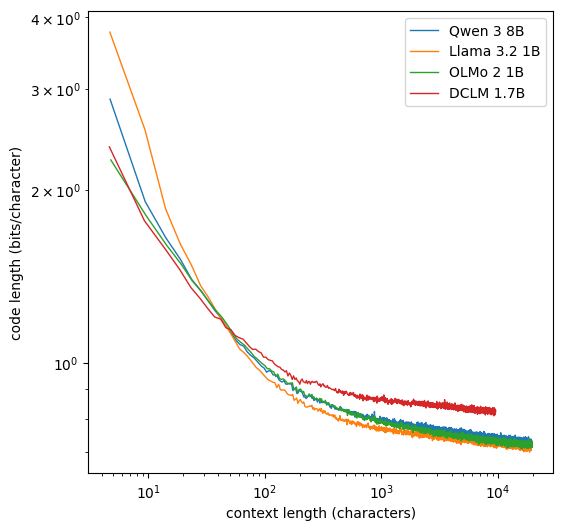

In [287]:
line_width = 0.5
marker_size = 1
model_names = {'qwen': "Qwen 3 8B", 'olmo': 'OLMo 2 1B', 'llama': 'Llama 3.2 1B', 'dclm': "DCLM 1.7B"}
# model_names = ["Qwen 3 8B", 'OLMo 2 1B', 'Llama 3.2 1B']


plt.figure(figsize=(6, 6))

for model in data:
    c_mean = codelength_data[model]['c_mean']
    c_sem = codelength_data[model]['c_sem']
    char_per_tok = chars_per_token[model]
        
    # Scale values by characters per token
    # need to multiply by 1 / char_per_tok --> divide by char_per_tok
    y_mean = c_mean / char_per_tok
    y_sem = c_sem / char_per_tok

    # X-axis (token positions)
    x_positions = (np.arange(len(y_mean)) + 1) * char_per_tok
    
    # Plot the mean line
    line, = plt.plot(x_positions, y_mean, lw=1, label=model_names[model])
    # print(model, model_names[model])

    # plt.fill_between(x_positions, y_mean - y_sem, y_mean + y_sem, color=line.get_color(), alpha=0.2)

    
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='both', which='major')
plt.tick_params(axis='both', which='minor')
plt.ylabel('code length (bits/character)')
plt.xlabel('context length (characters)')
plt.legend()

# # save as pdf
plt.savefig('c4_all_models.pdf', bbox_inches='tight')

In [288]:
for model in data:
    print(f'{model} samples: {avg_data[model]['n'][-1]}')

qwen samples: 30000
llama samples: 30000
olmo samples: 30000
dclm samples: 30000


In [99]:
c_std[-10:]

array([3.70022075, 3.72411333, 3.72576838, 3.72021532, 3.69171112,
       3.7058617 , 3.7073424 , 3.69704316, 3.68483972, 3.7152293 ])

In [104]:
data['olmo']['c'][:10]

array([[1.37684727e+01, 1.11712723e+01, 4.13542414e+00, ...,
        3.24402475e+00, 3.94747233e+00, 1.81775415e+00],
       [9.22586632e+00, 1.69712791e+01, 6.54646301e+00, ...,
        2.12430984e-01, 8.02820969e+00, 4.75094414e+00],
       [4.19912386e+00, 1.29475136e+01, 7.99257994e+00, ...,
        7.82748871e-03, 6.12385213e-01, 1.03574924e+01],
       ...,
       [1.74672127e+01, 5.92397356e+00, 1.45268221e+01, ...,
        1.30414212e+00, 2.25142852e-04, 2.29076176e+01],
       [9.55114460e+00, 1.51411295e+01, 7.88761616e+00, ...,
        1.26658094e+00, 7.78826904e+00, 6.49594050e-03],
       [9.82247734e+00, 1.57550154e+01, 8.52306557e+00, ...,
        2.55872846e-01, 2.14418426e-01, 4.68329430e-01]],
      shape=(10, 4095), dtype=float32)

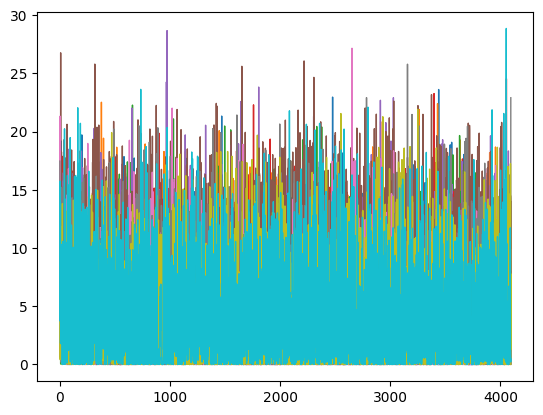

In [107]:
for i in range(10):
    plt.plot(xvals, data['olmo']['c'][i], lw=1)